Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# modify to where you store your project data including utils
# datadir = "/content/drive/My Drive/cs445_projects/mp5/" 
datadir = "/Users/kaushaldadi/Code/cs445_projects/mp5/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

cp: ./utils.py and /Users/kaushaldadi/Code/cs445_projects/mp5/utils.py are identical (not copied).
cp: ./images and /Users/kaushaldadi/Code/cs445_projects/mp5/images are identical (not copied).


In [ ]:
!pip uninstall opencv-python -y

In [ ]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [ ]:
!pip install sklearn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2951 sha256=9f208008c13beb48a93e870c20bf09c0f47d03c53157b0d631f86c74baadb63c
  Stored in directory: /Users/kaushaldadi/Library/Caches/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn


In [ ]:
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.11.45
!pip install ffmpeg-python # for converting to video
!pip install matplotlib

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

  Using cached opencv_contrib_python-3.4.11.45-cp39-cp39-macosx_10_13_x86_64.whl (60.5 MB)
  Using cached numpy-1.24.3-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.11.45
    Uninstalling opencv-contrib-python-3.4.11.45:
      Successfully uninstalled opencv-contrib-python-3.4.11.45
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 7.6 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.5 MB/s eta 0:00:0000:01
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_10_9_x86_64.whl (65 kB)
  Using cached Pillow-9.5.0-cp39-cp39-macosx_10_10_x86_64.whl (3.4 MB)
  Using ca

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [ ]:
def score_projection(pt1, pt2):
  '''
  Score corresponding to the number of inliers for RANSAC
  Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
  Outputs: score (scalar count of inliers) and inliers (1xN logical array)
  '''

  # TO DO
  threshold = 10
  dists = np.sqrt(np.sum((pt1 - pt2)**2, axis=0))
  inliers = dists < threshold
  score = np.sum(inliers)


  return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # TO DO: Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [ ]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    (_, n) = pts1.shape     
    A = np.zeros((2*n, 9))         
    A[:] = [[-pts1[:, i], 0, 0, pts1[:, i]*(pts2[0, i]/pts2[2,i]), 0, 0] if i % 2 == 0 else [0, -pts1[:, i], 0, 0, pts1[:, i]*(pts2[1, i]/pts2[2,i]), 0] for i in range(n)]
    u, s, vh = np.linalg.svd(A)     
    H = vh.T[:, -1]     
    H /= H[-1]
                   
    return H.reshape((3,3))

best score: 222.000000
[[ 1.00000000e+00  3.55982197e-02 -2.04016564e+02]
 [-9.64999321e-04  9.84328300e-01 -1.56255197e+01]
 [ 3.08190737e-04  1.53649872e-04  8.23473268e-01]]
Top left corner coordinates: (106, 85)


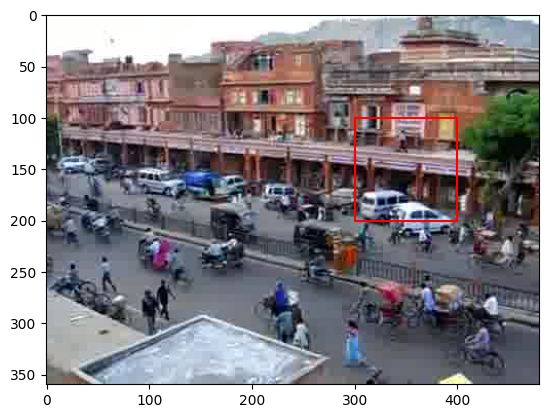

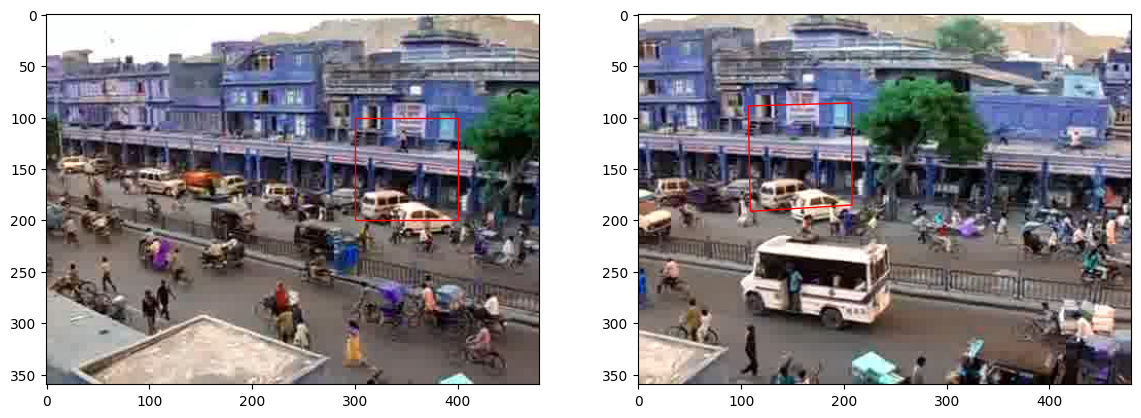

In [ ]:
import matplotlib.patches as patches

# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

points = np.array([[300,100,1], [400, 100, 1], [400, 200, 1], [300, 200, 1]]).T 
transformed_points = H @ points 
transformed_points /= transformed_points[2]

[ax.imshow(image) for (ax, image) in zip(axs, [im1, im2])]

[p.add_patch(patches.Polygon(points[:-1,:].T, fill=False, edgecolor='r')) for p in axs]
[p.add_patch(patches.Polygon(transformed_points[:-1,:].T, fill=False, edgecolor='r')) for p in axs]

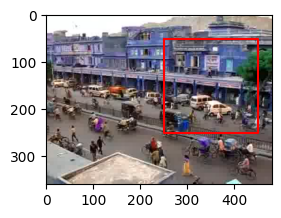

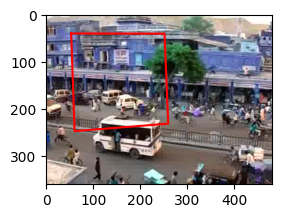

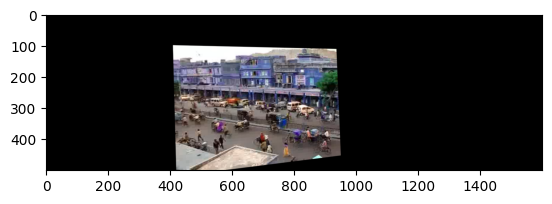

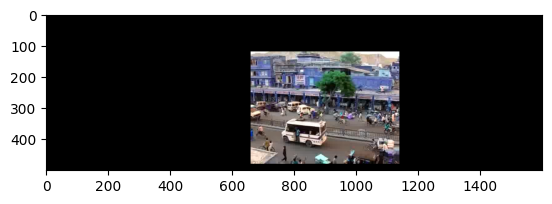

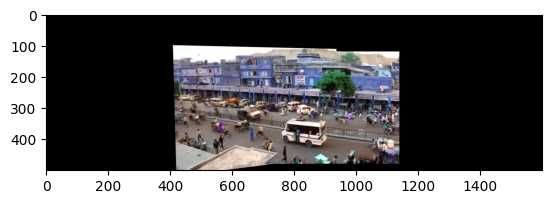

In [ ]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images
ri, rj = [250, 250, 450, 450, 250], [50, 250, 250, 50, 50]
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(im1), ax1.plot(ri, rj, 'r')
rect1_proj = np.dot(H, [ri, rj, [1]*5])/[1, 1, 1]
ax2.imshow(im2), ax2.plot(rect1_proj[0].tolist(), rect1_proj[1].tolist(), 'r')

image_corners = [[0, 0, len(im1[0]), len(im1[0])], [0, len(im1[1]), len(im1[1]), 0], [1]*4]
corners_warped = np.dot(H, image_corners)/[corners_warped[2]]*3

H_t, H_t2 = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]]), np.array([[1, 0, 660], [0, 1, 120]])

img_warped = cv2.warpPerspective(im1, np.dot(H_t, H), (projectedWidth, projectedHeight))
img_warped2 = cv2.warpAffine(im2, np.float32(H_t2), (projectedWidth, projectedHeight))

plt.imshow(img_warped), plt.figure(), plt.imshow(img_warped2)
img_warped, img_warped2 = np.float32(img_warped/255.0), np.float32(img_warped2/255.0)

canvas = np.zeros((img_warped.shape))
canvas[(img_warped2.any(axis=2))] = img_warped2[(img_warped2.any(axis=2))]
canvas[(~img_warped2.any(axis=2)) & (img_warped.any(axis=2))] = img_warped[(img_warped.any(axis=2))]

plt.figure(), plt.imshow(canvas)


### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 222.000000
best score: 215.000000
best score: 264.000000
best score: 151.000000
[[ 1.38524671e+00  8.02562927e-02 -5.27626900e+02]
 [ 5.84929753e-02  1.24610257e+00 -5.67810860e+01]
 [ 9.68916736e-04 -2.78788095e-05  9.35282027e-01]]
[[ 1.34718295e+00  6.70561852e-02 -2.83547243e+02]
 [ 7.69320172e-02  1.20037284e+00 -3.58893861e+01]
 [ 6.56532568e-04  1.91921617e-05  1.00000000e+00]]
[[ 7.92582120e-01 -1.00208537e-01  1.57224415e+02]
 [-3.06246323e-02  8.89045789e-01  2.29425056e+01]
 [-3.77121209e-04 -1.76064834e-04  1.00000000e+00]]
[[ 5.86423500e-01 -1.89626395e-01  3.13052119e+02]
 [-2.69034645e-02  8.24723883e-01  3.93881261e+01]
 [-6.36323186e-04 -2.19801394e-04  9.46074065e-01]]


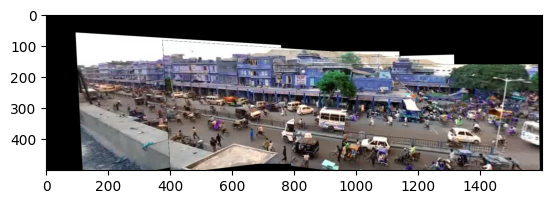

In [ ]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1
key_frames = np.array([90, 270, 450, 630, 810])

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

# images location
im90 = './images/input/frames/f0090.jpg'
im270 = './images/input/frames/f0270.jpg'
im450 = './images/input/frames/f0450.jpg'
im630 = './images/input/frames/f0630.jpg'
im810 = './images/input/frames/f0810.jpg'

# Load an color image in grayscale
im90, im270, im450, im630, im810 = [cv2.imread(f'./images/input/frames/f{i}.jpg') for i in [90, 270, 450, 630, 810]]

H_270_450 = auto_homography(im270, im450, computeHomography)
H_630_450 = auto_homography(im630, im450, computeHomography)
H_90_270 = auto_homography(im90, im270, computeHomography)
H_810_630 = auto_homography(im810, im630, computeHomography)
H_90_450, H_810_450 = np.dot(H_90_270, H_270_450), np.dot(H_810_630, H_630_450)

H_t, H_t2 = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]]), np.array([[1, 0, 660], [0, 1, 120]])

img_90 = cv2.warpPerspective(im90, np.dot(H_t,H_90_450), (1600, 500))
img_270 = cv2.warpPerspective(im270, np.dot(H_t,H_270_450), (1600, 500))
img_450 = cv2.warpAffine(im450, np.float32(H_t2), (1600, 500))
img_630 = cv2.warpPerspective(im630, np.dot(H_t,H_630_450), (1600, 500))
img_810 = cv2.warpPerspective(im810, np.dot(H_t,H_810_450), (1600, 500))

imgs = [img_810, img_630, img_450, img_270, img_90]
canvas = np.zeros(img_90.shape)

for i in range(500):
    for j in range(1600):
        for img in imgs:
            if img[i, j].any():
                canvas[i, j] = img[i, j]
            break

plt.figure()
plt.imshow(canvas)

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [ ]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)

In [ ]:
# TO DO part 3 solution

# REDEFINED FROM PART 2 JUST IN CASE
# images location
im90 = './images/input/frames/f0090.jpg'
im270 = './images/input/frames/f0270.jpg'
im450 = './images/input/frames/f0450.jpg'
im630 = './images/input/frames/f0630.jpg'
im810 = './images/input/frames/f0810.jpg'

# Load an color image in grayscale
im90, im270, im450, im630, im810 = [cv2.imread(f'./images/input/frames/f{i}.jpg') for i in [90, 270, 450, 630, 810]]

H_270_450 = auto_homography(im270, im450, computeHomography)
H_630_450 = auto_homography(im630, im450, computeHomography)
H_90_270 = auto_homography(im90, im270, computeHomography)
H_810_630 = auto_homography(im810, im630, computeHomography)
H_90_450, H_810_450 = np.dot(H_90_270, H_270_450), np.dot(H_810_630, H_630_450)

H_t = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
H_t2 = np.array([[1, 0, 660], [0, 1, 120]])

# create your video (see tips)

In [ ]:
os.mkdir("modified_frames")

In [ ]:
for idx, file_i in enumerate(filenames):
    img = cv2.imread(file_i)
    if idx < 90:
        H = auto_homography(img, img90, computeHomography)
        H = np.dot(H, H_90_450)
    elif idx < 270:
        H = auto_homography(img, img270, computeHomography)
        H = np.dot(H, H_270_450)
    elif idx <= 630:
        H = auto_homography(img, img450, computeHomography)
    elif idx <= 810:
        H = auto_homography(img, img630, computeHomography)
        H = np.dot(H, H_630_450)
    else:
        H = auto_homography(img, img810, computeHomography)
        H = np.dot(H, H_810_450)

    modified = cv2.warpPerspective(img, np.dot(H_t, H), (1600, 500))
    cv2.imwrite(f"modified_frames/a{idx:04d}.jpg", modified)

best score: 429.000000
best score: 429.000000
best score: 454.000000
best score: 445.000000
best score: 464.000000
best score: 451.000000
best score: 483.000000
best score: 459.000000
best score: 478.000000
best score: 498.000000
best score: 495.000000
best score: 484.000000
best score: 496.000000
best score: 482.000000
best score: 510.000000
best score: 508.000000
best score: 522.000000
best score: 509.000000
best score: 494.000000
best score: 498.000000
best score: 481.000000
best score: 494.000000
best score: 509.000000
best score: 497.000000
best score: 520.000000
best score: 504.000000
best score: 500.000000
best score: 525.000000
best score: 529.000000
best score: 513.000000
best score: 526.000000
best score: 525.000000
best score: 539.000000
best score: 546.000000
best score: 539.000000
best score: 555.000000
best score: 546.000000
best score: 533.000000
best score: 527.000000
best score: 559.000000
best score: 560.000000
best score: 558.000000
best score: 542.000000
best score:

In [ ]:
utils.imageFolder2mpeg('modified_frames', fps=30)

OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


/Users/kaushaldadi/Code/cs445_projects/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaushaldadi/Code/cs445_projects/env/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


True

/Users/kaushaldadi/Code/cs445_projects/env/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


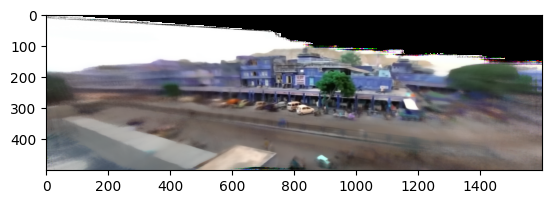

In [ ]:
# TO DO part 4
# Get sorted list of filenames in the directory
dir_frames = 'modified_frames'
filenames = sorted([f.path for f in os.scandir(dir_frames) if f.name.endswith(".jpg")], key=lambda f: int(''.join(filter(str.isdigit, f))))

# Load frames into a numpy array and normalize
frameCount = len(filenames)
projected_frames = np.array([cv2.imread(file_i) / 255.0 for file_i in filenames], dtype=np.float32)

# Compute background as median of non-zero pixels across frames
background = np.zeros((500, 1600, 3))
for i in range(500):
    for j in range(1600):
        for c in range(3):
            nonzero = np.nonzero(projected_frames[:, i, j, c])
            if len(nonzero) != 0:
                background[i][j][c] = np.median(projected_frames[nonzero, i, j, c])

# Display and save background image
plt.imshow(background)
cv2.imwrite('background.jpg', background*255)


### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
# TO DO part 5

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6


## Bells and whistles